# Housing ML Notebook

In [1]:
# Setup Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

# Display all rows and columns
pd.set_option("display.max_columns", None)

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2

In [3]:
# Used for auto-formatting code
# terminal - pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
# Import data csvs
X = pd.read_csv("data/predictors.csv")  # id=1 to 1460
Y = pd.read_csv("data/response.csv")  # id=1461-2919

# Save figures within notebook?
save_figures = 1  # 1 (yes); 0 (no)

<IPython.core.display.Javascript object>

In [5]:
# Dummify categorical predictors
X = pd.get_dummies(X, drop_first=True)  # dummify


<IPython.core.display.Javascript object>

In [6]:
# Separate train and test.csv dataframes
train_df = X.loc[X.Id <= 1460].drop("Id", axis=1)  # train.csv
test_df = X.loc[X.Id > 1460].drop("Id", axis=1)  # test.csv
response = Y

# Test-Train split **TRAIN.CSV DATA**
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    train_df, response, test_size=0.3, random_state=0
)

<IPython.core.display.Javascript object>

## LASSO REGRESSION

In [7]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

<IPython.core.display.Javascript object>

### Model Tuning: Original Features

Best Lambda:0.00011487
Train RMSE:0.11083
Test RMSE:0.10422

CPU times: user 9min 38s, sys: 47.5 s, total: 10min 25s
Wall time: 1min 32s


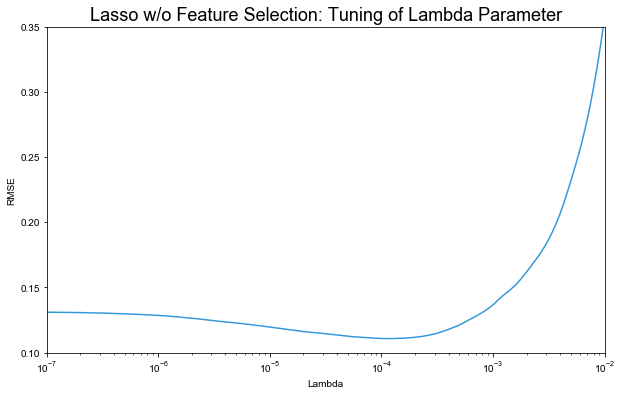

<IPython.core.display.Javascript object>

In [8]:
%%time

# Model Tuning
lasso = Lasso()  # instantize
store = []  # store alpha and rmse

min_a = -7 #used for plot
max_a = -2 #used for plot
alphas = np.logspace(min_a, max_a, 300)
for a in alphas:
    lasso.set_params(alpha=a, normalize = True, random_state=0)

    #calculate test and train rmse
    cv = KFold(5, shuffle=True, random_state=0)
    rmse_train = np.mean(-cross_val_score(
            lasso, x_train, y_train, scoring="neg_root_mean_squared_error", cv=cv))

    #store values for each iteration
    store.append([a, rmse_train])

#convert nested list to dataframe
results = pd.DataFrame(store, columns=["alpha", 'train_RMSE'])
results.sort_values(ascending=True, by="train_RMSE", inplace=True)
lasso_best_alpha = results.alpha.iloc[0]

# Test RMSE
lasso.set_params(alpha=lasso_best_alpha, normalize=True, random_state=0)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print("Best Lambda:{0}".format(round(lasso_best_alpha, 8)))
print("Train RMSE:{0}".format(round(results.train_RMSE.iloc[0], 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(data=results, x="alpha", y="train_RMSE", color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10**min_a, 10**max_a)
plt.ylim(0.10, 0.350)
plt.title("Lasso w/o Feature Selection: Tuning of Lambda Parameter")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures: plt.savefig("saved_figures/lasso_tuning.tiff", bbox_inches="tight", dpi=300)


### Feature Selection

#### Plot Feature Coefficients

CPU times: user 27.8 s, sys: 95.7 ms, total: 27.9 s
Wall time: 10.7 s


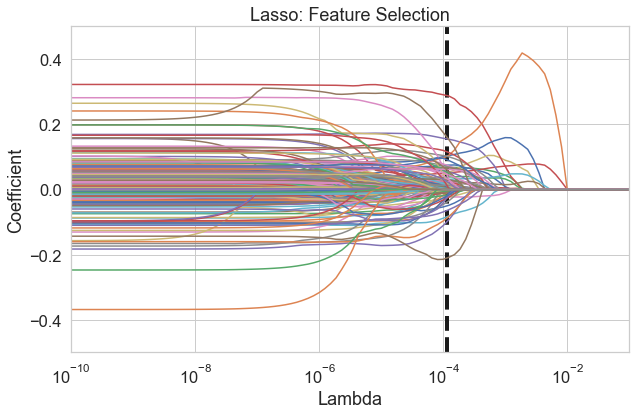

<IPython.core.display.Javascript object>

In [9]:
%%time

# Feature Selection
lasso = Lasso()  # instantize
store = []  # store coefficients

min_a = -10 #used for plot
max_a = -1 #used for plot
alphas = np.logspace(min_a, max_a, 100)
for a in alphas:
    lasso.set_params(alpha=a, normalize=True, random_state=0)
    lasso.fit(x_train, y_train) #fit model with training data
    store.append(lasso.coef_) #store coeffs per alpha

coeffs = pd.DataFrame(store, index=alphas, columns = x_train.columns)

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))

for feat in coeffs.columns.tolist():
    g = sns.lineplot(data=coeffs, x=coeffs.index, y=feat)
sns.set(style="whitegrid", font_scale=1.5)
plt.vlines(lasso_best_alpha, 
           -.5, 
           .5, 
           colors='k', 
           linestyles='dashed', 
           linewidth = 4,
           label='Lambda: {0}'.format(round(lasso_best_alpha, 8)))
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(-.5, .5)
g.set(xscale="log")
plt.title("Lasso: Feature Selection")
plt.xlabel("Lambda")
plt.ylabel("Coefficient")

if save_figures: plt.savefig("saved_figures/lasso_feat_perAlpha.tiff", bbox_inches="tight", dpi=300)


### Id all features with coefficients > 0

Lasso: important features = 84
Lasso: dropped features = 134


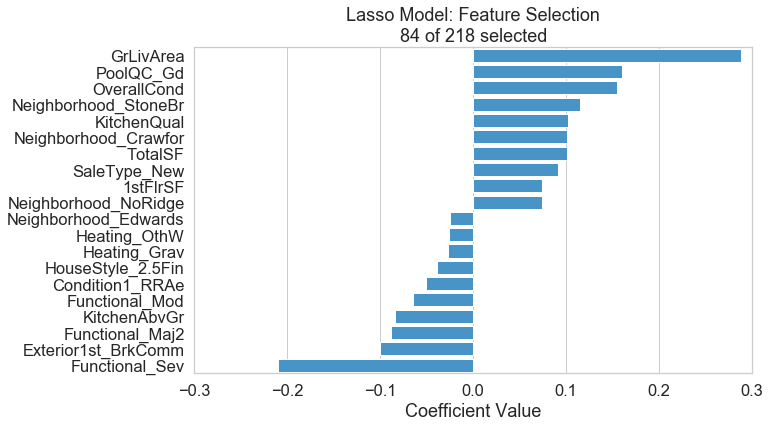

<IPython.core.display.Javascript object>

In [10]:
# Model
lasso.set_params(alpha=lasso_best_alpha, normalize=True, random_state=0)
lasso.fit(x_train, y_train)  # fit model with train data

# Create df of features and coefficients
coefs_df = pd.DataFrame(lasso.coef_, index=x_train.columns, columns=["coef"])
coefs_df.sort_values(ascending=False, by="coef", inplace=True)  # sort df
n_select = sum(coefs_df.coef != 0)  # features selected
n_drop = sum(coefs_df.coef == 0)  # features dropped
print("Lasso: important features = {0}".format(n_select))
print("Lasso: dropped features = {0}".format(n_drop))

# Plot coefficients of top _ important features
plt.figure(figsize=(10, 6))
data = pd.concat([coefs_df.head(10), coefs_df.tail(10)], axis=0)
sns.barplot(x=data.coef, y=data.index, color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
plt.title(
    "Lasso Model: Feature Selection\n{0} of {1} selected".format(
        n_select, n_select + n_drop
    )
)
plt.xlabel("Coefficient Value")
plt.xlim(-0.3, 0.3)

if save_figures:
    plt.savefig("saved_figures/lasso_feat_importance.tiff", bbox_inches="tight")

### Model Tuning of Only Selected Features

In [11]:
# Perform LASSO with only selected features
imp_feat = coefs_df.loc[coefs_df.coef != 0].index.tolist()
lasso.set_params(alpha=lasso_best_alpha, normalize=True, random_state=0)
lasso.fit(x_train[imp_feat], y_train)
y_pred_train = lasso.predict(x_train[imp_feat])
y_pred_test = lasso.predict(x_test[imp_feat])
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('Lasso: Before Feature Selection')
print("Train RMSE:{0}".format(round(results.train_RMSE.iloc[0], 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

print('Lasso: Only Important Features [n={0}]'.format(len(imp_feat)))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))


Lasso: Before Feature Selection
Train RMSE:0.11083
Test RMSE:0.10422

Lasso: Only Important Features [n=84]
Train RMSE:0.09795
Test RMSE:0.10422



<IPython.core.display.Javascript object>

Ridge: Before Feature Selection
Best Lambda:2.52e-05
Train RMSE:0.10681
Test RMSE:0.10422



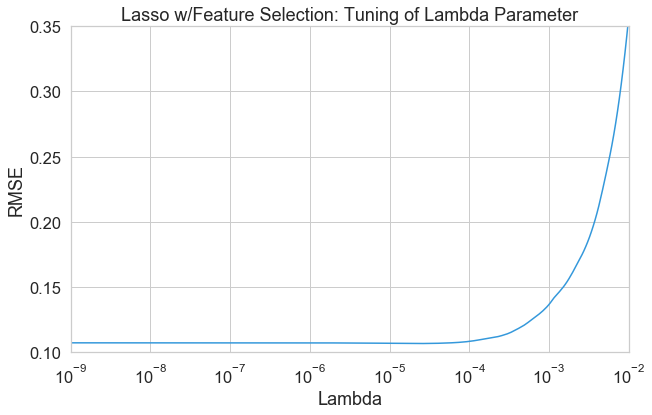

<IPython.core.display.Javascript object>

In [12]:
# Model Tuning
lasso_featSelect = Lasso()  # instantize
store = []  # store alpha and rmse

min_a = -9 #used for plot
max_a = -2 #used for plot
alphas = np.logspace(min_a, max_a, 300)
for a in alphas:
    lasso_featSelect.set_params(alpha=a, normalize = True, random_state=0)

    #calculate test and train rmse
    cv = KFold(5, shuffle=True, random_state=0)
    rmse_train = np.mean(-cross_val_score(
            lasso_featSelect, x_train[imp_feat], y_train, scoring="neg_root_mean_squared_error", cv=cv))

    #store values for each iteration
    store.append([a, rmse_train])

#convert nested list to dataframe
results = pd.DataFrame(store, columns=["alpha", 'train_RMSE'])
results.sort_values(ascending=True, by="train_RMSE", inplace=True)
lasso_featSelect_best_alpha = results.alpha.iloc[0]

# Test RMSE
lasso_featSelect.set_params(alpha=lasso_best_alpha, normalize=True, random_state=0)
lasso_featSelect.fit(x_train[imp_feat], y_train)
y_pred = lasso_featSelect.predict(x_test[imp_feat])
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print('Ridge: Before Feature Selection')
print("Best Lambda:{0}".format(round(lasso_featSelect_best_alpha, 8)))
print("Train RMSE:{0}".format(round(results.train_RMSE.iloc[0], 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(data=results, x="alpha", y="train_RMSE", color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10**min_a, 10**max_a)
plt.ylim(0.10, 0.350)
plt.title("Lasso w/Feature Selection: Tuning of Lambda Parameter")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures: plt.savefig("saved_figures/lasso_tuning_featSelect.tiff", bbox_inches="tight", dpi=300)


## RIDGE REGRESSION

In [13]:
from sklearn.linear_model import Ridge


<IPython.core.display.Javascript object>

### Ridge Before Feature Selection

Ridge: Only Important Features [n=84]
Best Lambda:0.21269594
Train RMSE:0.11365
Test RMSE:0.11011

CPU times: user 1min 23s, sys: 5.02 s, total: 1min 28s
Wall time: 13.5 s


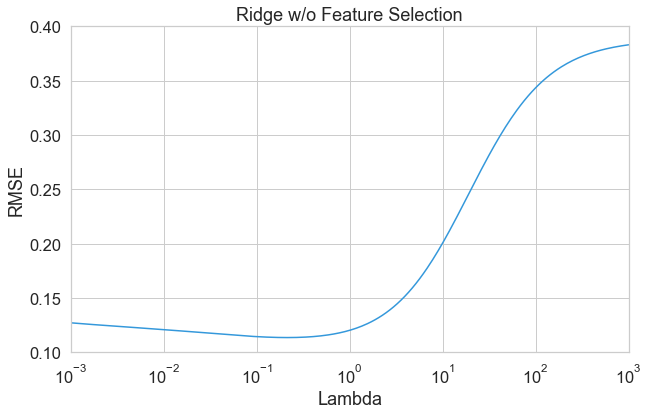

<IPython.core.display.Javascript object>

In [14]:
%%time

# Model Tuning
ridge = Ridge()  # instantize
store = []  # store alpha and rmse

min_a = -3 #used for plot
max_a = 3 #used for plot
alphas = np.logspace(min_a, max_a, 300)
for a in alphas:
    ridge.set_params(alpha=a, normalize = True, random_state=0)

    #calculate test and train rmse
    cv = KFold(5, shuffle=True, random_state=0)
    rmse_train = np.mean(-cross_val_score(
            ridge, x_train, y_train, scoring="neg_root_mean_squared_error", cv=cv))

    #store values for each iteration
    store.append([a, rmse_train])

#convert nested list to dataframe
results = pd.DataFrame(store, columns=["alpha", 'train_RMSE'])
results.sort_values(ascending=True, by="train_RMSE", inplace=True)
ridge_best_alpha = results.alpha.iloc[0]

# Test RMSE
ridge.set_params(alpha=ridge_best_alpha, normalize=True, random_state=0)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print('Ridge: Only Important Features [n={0}]'.format(len(imp_feat)))
print("Best Lambda:{0}".format(round(ridge_best_alpha, 8)))
print("Train RMSE:{0}".format(round(results.train_RMSE.iloc[0], 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(data=results, x="alpha", y="train_RMSE", color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10**min_a, 10**max_a)
plt.ylim(0.10, 0.4)
plt.title("Ridge w/o Feature Selection")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures: plt.savefig("saved_figures/ridge_tuning.tiff", bbox_inches="tight", dpi=300)


### Ridge After Feature Selection

Best Lambda:0.10155211
Train RMSE:0.10601
Test RMSE:0.10422



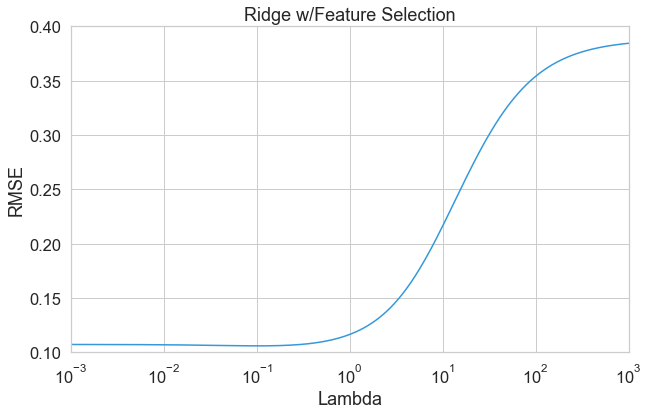

<IPython.core.display.Javascript object>

In [15]:
# Model Tuning
ridge_featSelect = Ridge()  # instantize
store = []  # store alpha and rmse

min_a = -3  # used for plot
max_a = 3  # used for plot
alphas = np.logspace(min_a, max_a, 300)
for a in alphas:
    ridge_featSelect.set_params(alpha=a, normalize=True, random_state=0)

    # calculate test and train rmse
    cv = KFold(5, shuffle=True, random_state=0)
    rmse_train = np.mean(
        -cross_val_score(
            ridge_featSelect,
            x_train[imp_feat],
            y_train,
            scoring="neg_root_mean_squared_error",
            cv=cv,
        )
    )

    # store values for each iteration
    store.append([a, rmse_train])

# convert nested list to dataframe
results = pd.DataFrame(store, columns=["alpha", "train_RMSE"])
results.sort_values(ascending=True, by="train_RMSE", inplace=True)
ridge_featSelect_best_alpha = results.alpha.iloc[0]

# Test RMSE
ridge_featSelect.set_params(alpha=ridge_best_alpha, normalize=True, random_state=0)
ridge_featSelect.fit(x_train[imp_feat], y_train)
y_pred = lasso_featSelect.predict(x_test[imp_feat])
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# print results
print("Best Lambda:{0}".format(round(ridge_featSelect_best_alpha, 8)))
print("Train RMSE:{0}".format(round(results.train_RMSE.iloc[0], 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))

# Plot Lambda vs RMSE
plt.figure(figsize=(10, 6))
g = sns.lineplot(data=results, x="alpha", y="train_RMSE", color="#3498db")
sns.set(style="whitegrid", font_scale=1.5)
g.set(xscale="log")
plt.xlim(10 ** min_a, 10 ** max_a)
plt.ylim(0.10, 0.4)
plt.title("Ridge w/Feature Selection")
plt.xlabel("Lambda")
plt.ylabel("RMSE")

if save_figures:
    plt.savefig(
        "saved_figures/Ridge_tuning_featSelect.tiff", bbox_inches="tight", dpi=300
    )



## ELASTIC-NET REGRESSION

In [16]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV


<IPython.core.display.Javascript object>

### Elastic-Net Before Feature Selection

In [18]:
%%time 

# Input for CV
min_a = -4  # used for plot
max_a = 4  # used for plot
param_grid = {'alpha': np.logspace(min_a, max_a, 300),
             'l1_ratio': [x / 1000 for x in range(630, 650, 1)]}

#Instantiate
elastic = ElasticNet(normalize = True, 
                     random_state=0,
                     n_jobs = -1)
cv = KFold(5, shuffle=True, random_state=0)
grid = GridSearchCV(estimator=elastic,
                    param_grid = param_grid,
                    scoring='neg_root_mean_squared_error',
                    verbose=True, 
                    cv=cv)
#Fit data
elastic_result = grid.fit(x_train, y_train)
elastic_best_alpha = elastic_result.best_estimator_.alpha #best rho
elastic_best_rho = elastic_result.best_estimator_.l1_ratio #RMSE
rmse_train = -elastic_result.best_score_ #RMSE

# Test results
y_pred = grid.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print('ElasticNet: All Features')
print("Best Lambda:{0}".format(round(ridge_best_alpha, 8)))
print("Best Rho:{0}".format(elastic_best_rho))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))


Fitting 5 folds for each of 6000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2315 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 4415 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 7619 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 14219 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 22019 tasks      | elapsed:   50.2s


ElasticNet: All Features
Best Lambda:0.21269594
Best Rho:0.64
Train RMSE:0.1106
Test RMSE:0.10476

CPU times: user 32.4 s, sys: 1.3 s, total: 33.7 s
Wall time: 1min 4s


[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:  1.1min finished


<IPython.core.display.Javascript object>

### Elastic-Net After Feature Selection

In [35]:
%%time 

# Input for CV
min_a = -6  # used for plot
max_a = -3  # used for plot
param_grid = {'alpha': np.logspace(min_a, max_a, 100),
             'l1_ratio': [x / 1000 for x in range(0, 10, 2)]}

#Instantiate
elastic = ElasticNet(normalize = True, random_state=0, n_jobs=-1)
cv = KFold(5, shuffle=True, random_state=0)
elast_featSelect = GridSearchCV(estimator=elastic,
                                param_grid = param_grid,
                                scoring='neg_root_mean_squared_error',
                                verbose=True,
                                cv=cv)
#Fit data
elastic_featSelect_result = elast_featSelect.fit(x_train[imp_feat], y_train)
elastic_featSelect_best_alpha = elastic_featSelect_result.best_estimator_.alpha #best rho
elastic_featSelect_best_rho = elastic_featSelect_result.best_estimator_.l1_ratio #RMSE
rmse_train = -elastic_featSelect_result.best_score_ #RMSE

# Test results
y_pred = elast_featSelect.predict(x_test[imp_feat])
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print('ElasticNet: Only Selected Features')
print("Best Lambda:{0}".format(round(elastic_featSelect_best_alpha, 8)))
print("Best Rho:{0}".format(elastic_featSelect_best_rho))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ElasticNet: All Features
Best Lambda:0.00012328
Best Rho:0.0
Train RMSE:0.10601
Test RMSE:0.10809

CPU times: user 5min 45s, sys: 22.5 s, total: 6min 7s
Wall time: 52.9 s


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   52.8s finished


<IPython.core.display.Javascript object>

## eXtremeGradientBoost Regression


In [36]:
import xgboost as xgb

<IPython.core.display.Javascript object>

In [63]:
[x / 10 for x in range(1, 11, 1)]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

<IPython.core.display.Javascript object>

In [ ]:
%%time 

# Input for CV
param_grid = {'eta': [0.3], # learning rate
              'min_child_weight': [1], #min sum weights required in child
              'max_depth': [6], #max depth of tree
              'gamma': [0], #specifies min loss reduction for split
              'subsample': [1], #frac of obvs. randomly sampled per tree
              'colsample_bytree': [1], #frac of col. used per tree
              'lambda': [1], #L2 Ridge regularization
              'alpha': [0], #L1 Lasso regularization
              'n_estimators': range(100, 2000, 100), #number of trees
             }

# Instantiate
xgb_model = xgb.XGBRegressor(silent=True, 
                             random_state=0, 
                             n_jobs=-1, 
                             early_stopping_rounds = 5)
cv = KFold(5, shuffle=True, random_state=0)
xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid=param_grid,
                        scoring="neg_root_mean_squared_error",
                        verbose=True,
                        cv=cv)
#Fit data
xgb_result = xgb_grid.fit(x_train, y_train)
rmse_train = -xgb_result.best_score_ #RMSE

# Test results
y_pred = xgb_grid.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#print results
print('XGBoost: All Features')
print("Best parameters:\n{0}".format(xgb_result.best_params_))
print("Train RMSE:{0}".format(round(rmse_train, 5)))
print("Test RMSE:{0}\n".format(round(rmse_test, 5)))


# Train RMSE:0.12157
# Test RMSE:0.1106

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
